# Neural Fields II: Solving PDE’s

Neural fields as Physics informed networks

Example:

$$\nabla^2 V = 0$$

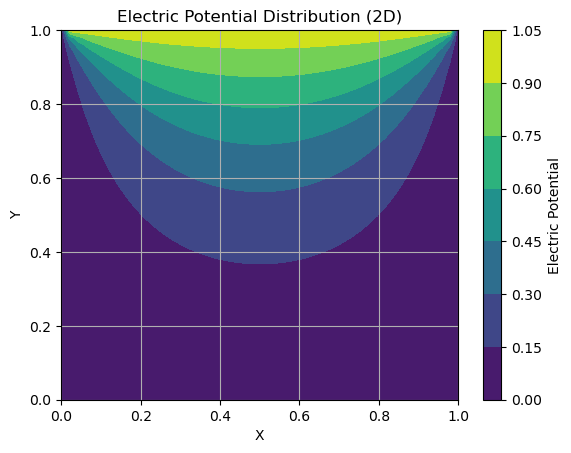

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain
length_x = 1.0
length_y = 1.0
num_points_x = 50
num_points_y = 50
dx = length_x / (num_points_x - 1)
dy = length_y / (num_points_y - 1)
x = np.linspace(0, length_x, num_points_x)
y = np.linspace(0, length_y, num_points_y)
X, Y = np.meshgrid(x, y)

# Define the boundary conditions
boundary_top = 1.0
boundary_bottom = 0.0
boundary_left = 0.0
boundary_right = 0.0

# Initialize the electric potential matrix with boundary conditions
potential = np.zeros((num_points_y, num_points_x))
potential[0, :] = boundary_bottom  # Bottom boundary
potential[-1, :] = boundary_top  # Top boundary
potential[:, 0] = boundary_left  # Left boundary
potential[:, -1] = boundary_right  # Right boundary

# Define the tolerance and maximum number of iterations for convergence
tolerance = 1e-6
max_iterations = 1000

# Solve the Laplace equation using the finite difference method
for iteration in range(max_iterations):
    previous_potential = np.copy(potential)
    
    # Finite difference approximation for Laplace equation: ∇^2(V) = 0
    # In 2D, this simplifies to V_xx + V_yy = 0
    # The finite difference approximation for the second derivative is:
    # V_xx ≈ (V(i+1,j) - 2*V(i,j) + V(i-1,j)) / dx^2
    # V_yy ≈ (V(i,j+1) - 2*V(i,j) + V(i,j-1)) / dy^2
    # We update the potential at each interior point using the average of its neighbors
    for i in range(1, num_points_y - 1):
        for j in range(1, num_points_x - 1):
            potential[i, j] = 0.25 * (potential[i+1, j] + potential[i-1, j] +
                                      potential[i, j+1] + potential[i, j-1])
    
    # Check for convergence
    if np.max(np.abs(potential - previous_potential)) < tolerance:
        break

# Plot the electric potential as a 2D contour plot
plt.contourf(X, Y, potential, cmap='viridis')
plt.colorbar(label='Electric Potential')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Electric Potential Distribution (2D)')
plt.grid(True)
plt.show()


## PINN network solution to Voltage potential

Epoch 0, Loss: 0.010084067471325397
Epoch 100, Loss: 4.562537014862755e-06
Epoch 200, Loss: 2.6330540094932076e-06
Epoch 300, Loss: 1.661478108871961e-06
Epoch 400, Loss: 1.0835666444108938e-06
Epoch 500, Loss: 7.555397019132215e-07
Epoch 600, Loss: 5.701269287783362e-07
Epoch 700, Loss: 4.587512876241817e-07
Epoch 800, Loss: 3.849648919640458e-07
Epoch 900, Loss: 3.315006722459657e-07
Epoch 1000, Loss: 2.902814628669148e-07
Epoch 1100, Loss: 2.571778736637498e-07
Epoch 1200, Loss: 2.2979153868618596e-07
Epoch 1300, Loss: 2.0661525468312902e-07
Epoch 1400, Loss: 5.853133302480273e-07
Epoch 1500, Loss: 1.7284635589476238e-07
Epoch 1600, Loss: 1.5849855117266998e-07
Epoch 1700, Loss: 1.457150631267723e-07
Epoch 1800, Loss: 1.6095222576950619e-07
Epoch 1900, Loss: 1.2713707064904156e-07
Epoch 2000, Loss: 1.1799374988186173e-07
Epoch 2100, Loss: 1.0975202258123318e-07
Epoch 2200, Loss: 1.6146972484420985e-05
Epoch 2300, Loss: 9.749329876740376e-08
Epoch 2400, Loss: 9.068710937754076e-08
Ep

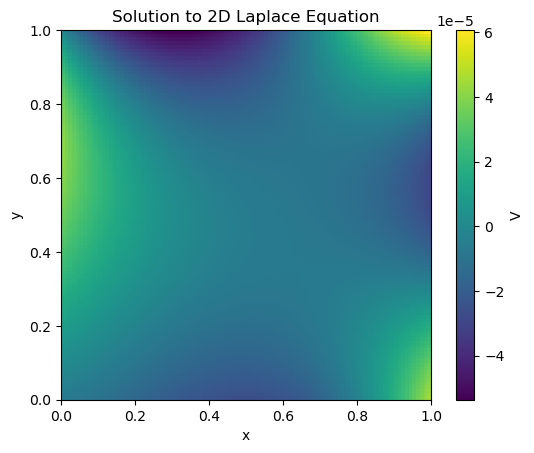

In [163]:
import torch
import torch.nn as nn
import numpy as np

# Define the neural network architecture
class PINN2D(nn.Module):
    def __init__(self):
        super(PINN2D, self).__init__()
        self.dense1 = nn.Linear(2, 50)
        self.dense2 = nn.Linear(50, 50)
        self.dense3 = nn.Linear(50, 1)

    def forward(self, inputs):
        x = torch.tanh(self.dense1(inputs))
        x = torch.tanh(self.dense2(x))
        x = self.dense3(x)
        return x

# Define the loss function
def loss(model, inputs, boundary_inputs, boundary_outputs):
    inputs.requires_grad = True
    boundary_inputs.requires_grad = True

    predictions = model(inputs)
    grad_x = torch.autograd.grad(predictions, inputs, grad_outputs=torch.ones_like(predictions), create_graph=True)[0]
    grad_xx = torch.autograd.grad(grad_x[:, 0], inputs, grad_outputs=torch.ones_like(grad_x[:, 0]), create_graph=True)[0]
    grad_yy = torch.autograd.grad(grad_x[:, 1], inputs, grad_outputs=torch.ones_like(grad_x[:, 1]), create_graph=True)[0]
    laplacian = grad_xx[:, 0] + grad_yy[:, 1]
    boundary_predictions = model(boundary_inputs)

    laplacian_loss = torch.mean(torch.square(laplacian))
    boundary_loss = torch.mean(torch.square(boundary_predictions - boundary_outputs))
    total_loss = laplacian_loss + boundary_loss
    return total_loss
device='cpu'
# Generate training data
n_points = 100
x = torch.linspace(0, 1, n_points)
X, Y = torch.meshgrid(x, x)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
xy_train = torch.cat([X, Y], axis=1).to(device)

boundary_mask_x = (X == 0) | (X == 1)
boundary_mask_y = (Y == 0) | (Y == 1)
boundary_mask = boundary_mask_x | boundary_mask_y

# Reshape the mask to match the shape of the points
boundary_mask = boundary_mask.view(-1)

# Apply the mask to get boundary points
boundary_inputs = xy_train[boundary_mask]
boundary_outputs = torch.zeros(boundary_inputs.shape[0]).to(device)

# Initialize model
model = PINN2D()

model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss_value = loss(model, xy_train, boundary_inputs, boundary_outputs)
    loss_value.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.item()}")

# Evaluate the trained model on a grid
x_test = torch.linspace(0, 1, n_points)
X_test, Y_test = torch.meshgrid(x_test, x_test)
xy_test = torch.cat([X_test.reshape(-1, 1), Y_test.reshape(-1, 1)], axis=1).to(device)
import time
time_s = time.time()
predictions = model(xy_test).cpu().detach().numpy().reshape(n_points, n_points)
print(f"time taken is: {time.time() - time_s}")

# Plot the solution
import matplotlib.pyplot as plt
plt.imshow(predictions, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar(label='V')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution to 2D Laplace Equation')
plt.show()

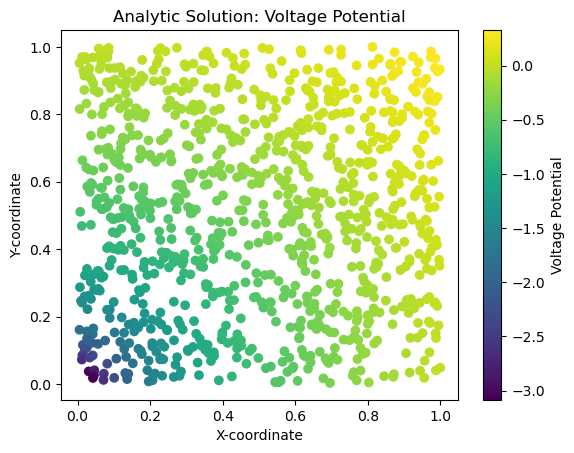

# Radiance Fields: NeRF & Gaussian splatter

**Paper:** 3D Gaussian Splatting for Real-Time Radiance Field Rendering & [NeRF: Representing Scenes as
Neural Radiance Fields for View Synthesis](https://arxiv.org/pdf/2003.08934.pdf)

A radiance field represents the radiance distribution over a region of space or a surface. It characterizes how radiance varies spatially and directionally within a scene.

An Example of the goal to be accomplished:
- a simple network

Epoch [10/100], Loss: 0.0814
Epoch [20/100], Loss: 0.0500
Epoch [30/100], Loss: 0.0281
Epoch [40/100], Loss: 0.0130
Epoch [50/100], Loss: 0.0067
Epoch [60/100], Loss: 0.0057
Epoch [70/100], Loss: 0.0051
Epoch [80/100], Loss: 0.0044
Epoch [90/100], Loss: 0.0040


Epoch [100/100], Loss: 0.0038


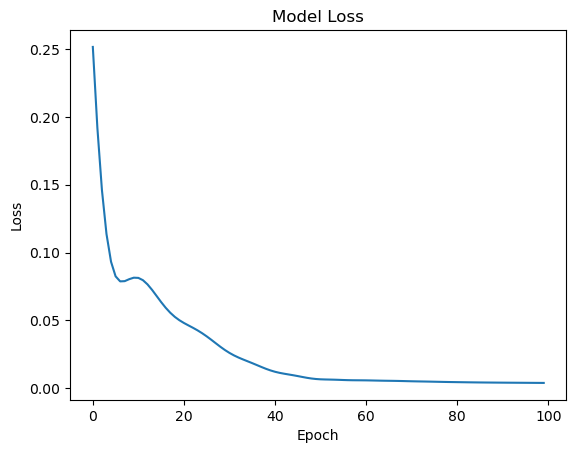

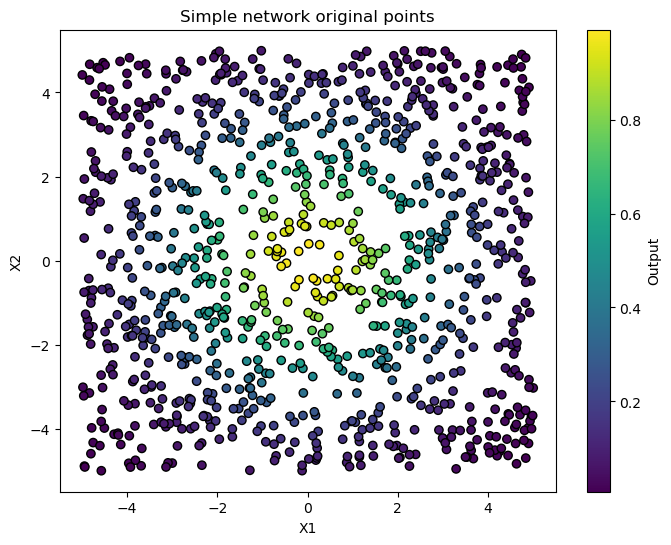

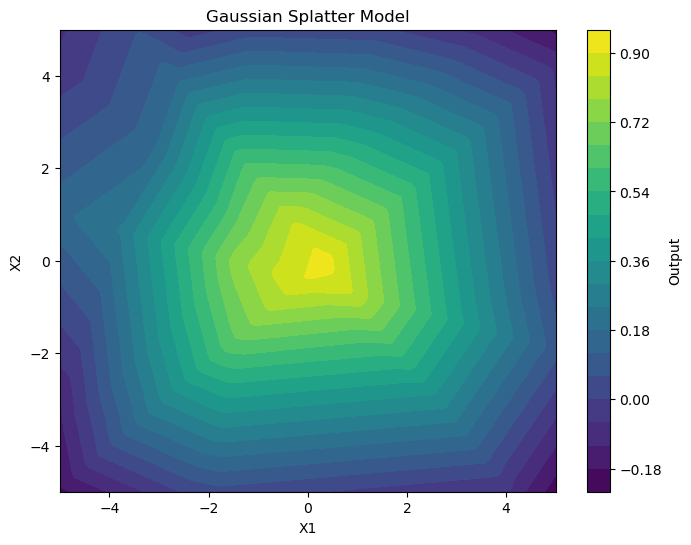

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic data
def generate_data(n_samples):
    np.random.seed(0)
    x = np.random.rand(n_samples, 2) * 10 - 5  # Random points in [-5, 5] x [-5, 5]
    y = np.exp(-(x[:, 0]**2 + x[:, 1]**2) / 10)  # Gaussian splatter
    return x, y

# Define the model
class GaussianModel(nn.Module):
    def __init__(self):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate training data
x_train, y_train = generate_data(1000)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

# Define model, loss function, and optimizer
model = GaussianModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot loss
plt.plot(losses)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize the results
def visualize_results(model):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    xx, yy = np.meshgrid(x, y)
    xy = np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))
    xy_tensor = torch.tensor(xy, dtype=torch.float32)
    with torch.no_grad():
        zz = model(xy_tensor).numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    dd = plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='viridis', edgecolors='k')
    plt.colorbar(dd, label='Output')
    plt.title('Simple network original points')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, zz, levels=20, cmap='viridis')
    plt.colorbar(label='Output')
    # plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='viridis', edgecolors='k')
    plt.title('Gaussian Splatter Model')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Visualize the results
visualize_results(model)


## NeRF

- referenced a contious scene as a 5D vector [x, y, z, $\theta$, $\phi$] and output is a the RGB colour vector c = [R,G,B] and volume density $\sigma$

- Neural Network based, commonly with MLP connections.

## Gaussian Splatting

- thought of as an alternative to NeRF like models.

- does not involve any network. Classical appraoch.

- stems from “Surface splatting” [Zwicker, M., et al](https://www.cs.umd.edu/~zwicker/publications/SurfaceSplatting-SIG01.pdf)

- near real time readering speeds.

- treats "scenes" essentially as points in space.

These 3D points that represent the observations are themseves a Gaussian, each with a unique set of parameters fitted for each scene. each Gaussian is parameterized by:

- the mean $\mu$, interpreted as x,y,z location.
- it's covariance $\Sigma$. Is isotropic by design meaning the a point can be an elipsiod that is rotated and or stretched along any direction in the space. Could add more parameters to but the matrix must be positive semi-definite in order to work with optimization.
- sigmoid function $\sigma(\alpha)$ that maps the parameter to a [0, 1] interval.
- parameter property. (commonly R,G,B or spherical harmonics coefficents) 

## Image formation model & rendering

With Gaussian splatting we can test an arbtrary point can be tested with the following:

$$
f_i(p) = \sigma(\alpha_i)\exp(-\frac{1}{2}(p - \mu_i)\Sigma^{-1}_i(p - \mu_i))
$$
<center><img src="01.png"/></center>

Similarity to a mutivariate normal distribution?!

**Now to rendering and image formation!**

Interestingly NeRF's and Gaussian splatting share the same image formation model.

- Volume rendering in NeRF:

$$
C(p) = \sum_{i=1}^N c_i \alpha_i \prod_{j=1}^{i-1} (1 - \alpha_j)
$$

where $\alpha_i = (1 - \exp(-\delta_i \sigma_i))$ and $1 - \alpha_j = \exp(-\delta_i \sigma_i)$

$\prod_{j=1}^{i-1} (1 - \alpha_j)$ is the transmittance.

- $\delta_i = t_i+1 − t_i$ is the distance between adjacent samples and $ \sigma_i$ is the opacity.

In short: 

color in a pixel p is approximated by integrating over samples along the ray going through this pixel. The final color is a weighted sum of colors of 3D points sampled along this ray, down-weighted by transmittance.

**Volume rendering in Gaussian splatting**

$$
C(p) = \sum_{i=1}^N c_i f^{2D}_i(p) \prod_{j=1}^{i-1} (1 - f^{2D}_i(p))
$$

The only difference is how $\alpha$ is calculated. Small difference but this is what drastically increases the rendering speed! This enables the rea time performance of splatting.

<center><img src="02.png"/></center>

## Optimization

The key to getting good renders is 3 components: 
- good initialization
- differentiable optimization
- adaptive densification.

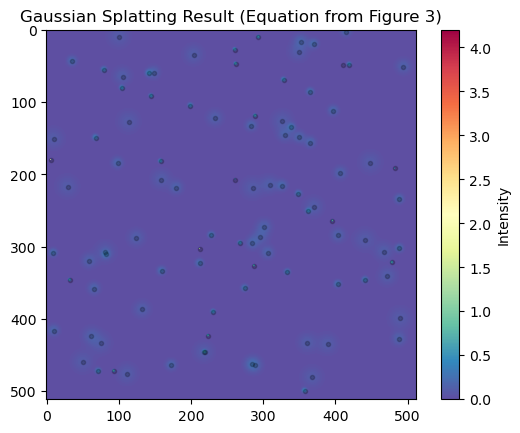

In [160]:
import numpy as np

def gaussian_splatting_equation(points, image_shape, sigmas):
    """
    Perform Gaussian splatting using the equation from Figure 3 of the referenced article.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 2) representing 2D positions (x, y) of points.
    image_shape : tuple
        Tuple representing the shape (height, width) of the output image.
    sigmas : numpy.ndarray
        Array of shape (N,) representing the standard deviations for each point.

    Returns:
    numpy.ndarray
        An image with the splatted points.
    """
    height, width = image_shape
    image = np.zeros(image_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y, indexing='xy')

    for i, point in enumerate(points):
        # Calculate the Gaussian kernel
        dx = X - point[0]
        dy = Y - point[1]
        d_squared = dx**2 + dy**2
        kernel = (1 / sigmas[i]) * np.exp(-0.5 * d_squared / sigmas[i]**2)

        # Update the image by adding the weighted Gaussian kernel
        image += kernel

    return image

# Example usage:
# Generate random 2D points and sigmas
np.random.seed(0)
num_points = 100
points = np.random.rand(num_points, 2) * 500  # Random points in a 100x100 space
sigmas = np.random.rand(num_points) * 10  # Random sigmas

# Define image shape
image_shape = (512, 512)

# Perform Gaussian splatting using the equation
result_image = gaussian_splatting_equation(points, image_shape, sigmas)

# Plot the result
plt.imshow(result_image, cmap='Spectral_r')
plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result (Equation from Figure 3)')
plt.show()


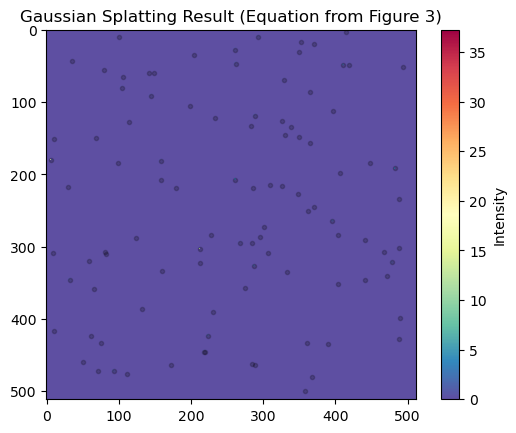

In [161]:
def gaussian_splatting_gradient(points, image_shape, sigmas):
    """
    Perform Gaussian splatting using the equation from Figure 3 of the referenced article.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 2) representing 2D positions (x, y) of points.
    image_shape : tuple
        Tuple representing the shape (height, width) of the output image.
    sigmas : numpy.ndarray
        Array of shape (N,) representing the standard deviations for each point.

    Returns:
    numpy.ndarray
        An image with the splatted points.
    """
    height, width = image_shape
    image = np.zeros(image_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y, indexing='xy')

    for i, point in enumerate(points):
        # Calculate the Gaussian kernel
        dx = X - point[0]
        dy = Y - point[1]
        d_squared = dx**2 + dy**2
        z = -0.5 * d_squared / sigmas[i]**2
        kernel = (1 / sigmas[i]) * np.exp(z) * ((d_squared) / sigmas[i]**3)

        # Update the image by adding the weighted Gaussian kernel
        image += kernel

    return image

# Define image shape
image_shape = (512, 512)

# Perform Gaussian splatting using the equation
result_image = gaussian_splatting_gradient(points, image_shape, sigmas)

# Plot the result
plt.imshow(result_image, cmap='Spectral_r')
plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result (Equation from Figure 3)')
plt.show()

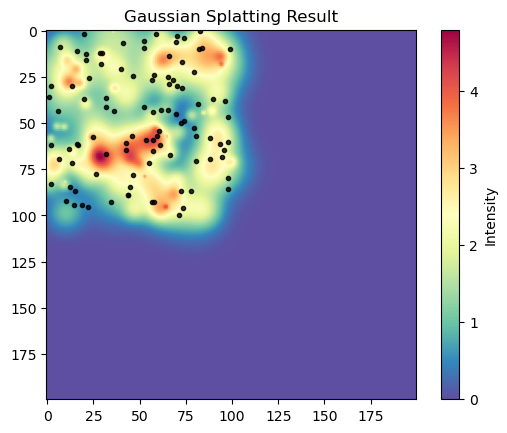

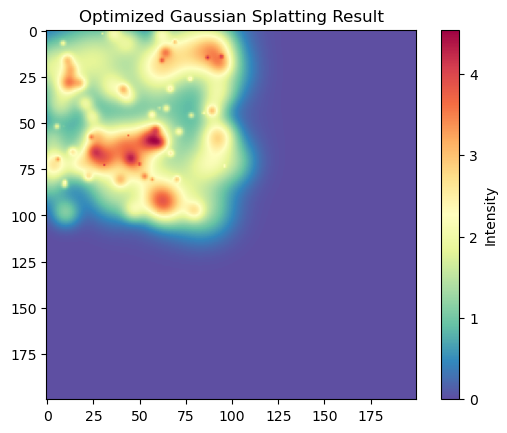

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def gaussian_splatting(points, image_shape, sigmas):
    """
    Perform Gaussian splatting using the equation from Figure 3 of the referenced article.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 2) representing 2D points (x, y).
    image_shape : tuple
        Tuple representing the shape (height, width) of the output image.
    sigmas : numpy.ndarray
        Array of shape (N,) representing the sigmas (spread) of the Gaussian splats.

    Returns:
    numpy.ndarray
        A 2D image with the splatted points.
    """
    height, width = image_shape
    image = np.zeros(image_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y, indexing='ij')

    for point, sigma in zip(points, sigmas):
        # Calculate the Gaussian kernel
        dx = X - point[0]
        dy = Y - point[1]
        d_squared = dx**2 + dy**2
        kernel = np.exp(-0.5 * d_squared / sigma**2)

        # Update the image by adding the Gaussian kernel
        image += kernel

    return image

# Example usage:
# Generate random 2D points and sigmas
np.random.seed(0)
num_points = 100
points = np.random.rand(num_points, 2) * 100  # Random points in a 100x100 space
sigmas = np.random.rand(num_points) * 10  # Random sigmas for the points

# Define image shape
image_shape = (200, 200)

# Perform Gaussian splatting
result_image = gaussian_splatting(points, image_shape, sigmas)

# Plot the result
plt.imshow(result_image, cmap='Spectral_r')
plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.82)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result')
plt.show()

# Define the objective function for optimization
def objective_function(x):
    """
    Objective function for optimization.

    Parameters:
    x : numpy.ndarray
        Array of shape (N,) representing the sigmas (spread) of the Gaussian splats.

    Returns:
    float
        The objective function value.
    """
    image = gaussian_splatting(points, image_shape, x)
    difference = result_image - image
    return np.sum(difference**2)

# Perform optimization to find the optimal sigmas
initial_sigmas = np.random.rand(num_points) * 10  # Initial guess for sigmas
result = minimize(objective_function, initial_sigmas, method='Nelder-Mead')

# Get the optimized sigmas
optimized_sigmas = result.x

# Perform Gaussian splatting with the optimized sigmas
optimized_image = gaussian_splatting(points, image_shape, optimized_sigmas)

# Plot the optimized result
plt.imshow(optimized_image, cmap='Spectral_r')
plt.colorbar(label='Intensity')
plt.title('Optimized Gaussian Splatting Result')
plt.show()


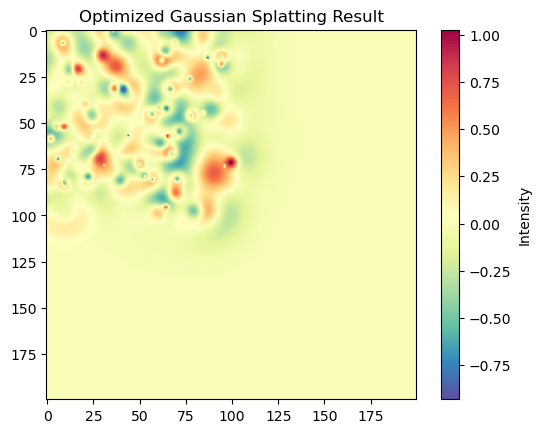

In [141]:
plt.imshow(result_image - optimized_image, cmap='Spectral_r')
plt.colorbar(label='Intensity')
plt.title('Optimized Gaussian Splatting Result')
plt.show()

# Limitations 
[comprehensive guide](https://towardsdatascience.com/a-comprehensive-overview-of-gaussian-splatting-e7d570081362)

"Despite the overall great results and the impressive rendering speed, the simplicity of the representation comes with a price. The most significant consideration is various regularization heuristics that are introduced during optimization to guard the model against “broken” Gaussians: points that are too big, too long, redundant, etc. This part is crucial and the mentioned issues can be further amplified in tasks beyond novel view rendering.

The choice to step aside from a continuous representation in favor of a discrete one means that the inductive bias of MLPs is lost. In NeRFs, an MLP performs an implicit interpolation and smoothes out possible inconsistencies between given views, while 3D Gaussians are more sensitive, leading back to the problem described above.

Furthermore, Gaussian splatting is not free from some well-known artifacts present in NeRFs which they both inherit from the shared image formation model: lower quality in less seen or unseen regions, floaters close to an image plane, etc."

## Look at some dcip data

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]

  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_12037/502153467.py:93: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_12037/502153467.py:118: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_12037/502153467.py:122: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarn

0.05003490350209774
5.62537967422244
0.0939381142077316
0.2037967635624132


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

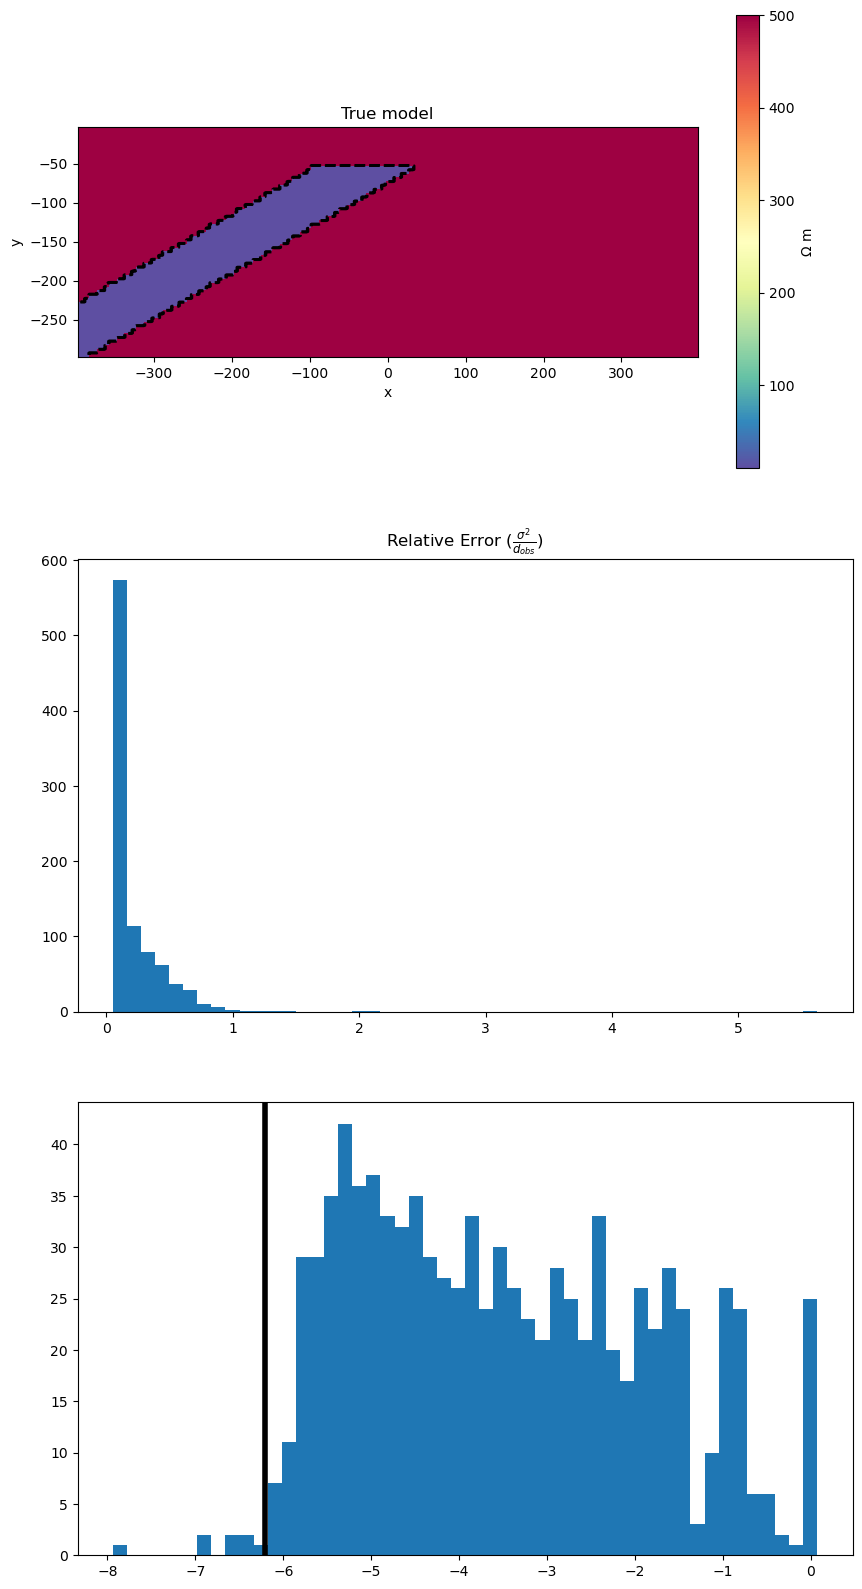

In [170]:
# import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

res_true[index_deep] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=5e-4,
    force=True,
    add_noise=True,

)

dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.008)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.008)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

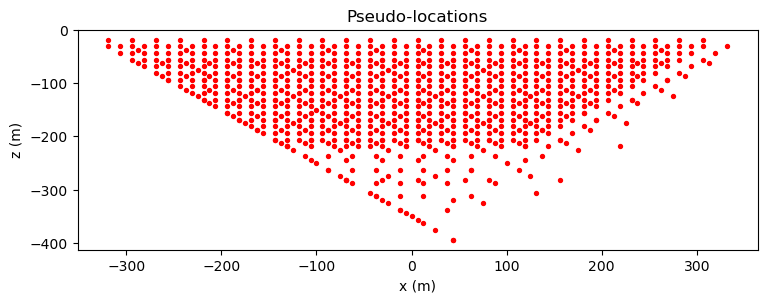

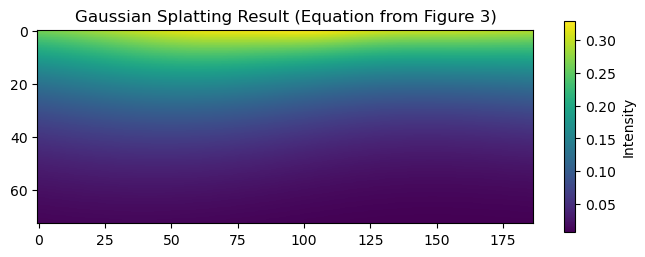

/tmp/ipykernel_12037/631894793.py:35: UserWarning: plot_pseudosection unused kwargs: ['units']
  plot_pseudosection(


(<Axes: xlabel='Line position (m)', ylabel='Pseudo-elevation (m)'>,
 <matplotlib.tri._tricontour.TriContourSet at 0x738f6b9a04d0>)

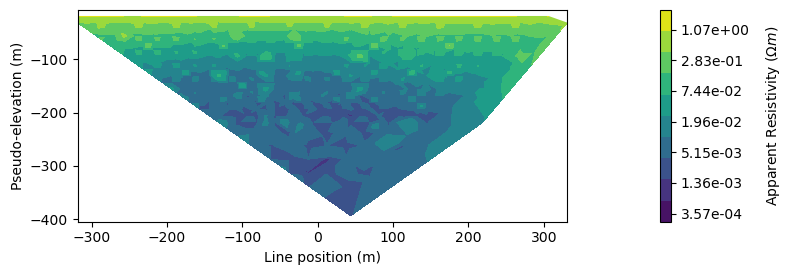

In [203]:
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, 'r')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Pseudo-locations')
plt.show()

sigmas = np.random.rand(survey.nD) * 50  # Random sigmas
points = pseudo_locations_xz
# Define image shape
image_shape = (len(mesh.h[1]), len(mesh.h[0]))

# Perform Gaussian splatting using the equation
result_image = gaussian_splatting_equation(points, image_shape, sigmas)

# Plot the result
fig = plt.figure(figsize=(8, 2.75))
plt.imshow(result_image, cmap='viridis')
# plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result (Equation from Figure 3)')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 2.75))

plot_pseudosection(
    dc_data.survey,
    dc_data.dobs,
    data_type="volts",
    scale="log",
    units="$\Omega m$",
    ax=ax,
    cbar_label="Apparent Resistivity ($\Omega m$)",
    mask_topography=True,
    plot_type="contourf",
    cbar_opts={"pad": 0.15},
)

## plans

- Modify the loss to fit the data given a model output from the Gaussian splatter given a set of $\sigma$'s?

$$
\phi = \frac{1}{2} || W(F(g(\sigma)) - d_{obs})||^2
$$

# 3D Rendering

In [190]:
import torch

depth, height, width = (64, 64, 64)
volume = torch.zeros((64, 64, 64))

# Define a grid of coordinates
x = torch.arange(width)
y = torch.arange(height)
z = torch.arange(depth)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

# Define a tensor
x = torch.tensor([1.0])

# Compute sigmoid of the tensor
sigmoid_x = torch.sigmoid(x)

print(sigmoid_x)

# for point, intensity in zip(points, intensities):
    # Calculate the Gaussian kernel
mu = torch.asarray([points[0], points[1], points[2]])
p = torch.asarray([X[0, 0, 0], Y[0, 0, 0], Z[0, 0,0]])
sigma = torch.tensor([[2.0,4.0,2.0], [5.0,6.0,6.0], [7.0,8.0,1.0]])

# Define a sample matrix

# Perform eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eig(sigma)
# d_squared = (p - mu)**2

# kernel = sigmoid_x * torch.exp(-0.5 * d_squared / sigma)


tensor([0.7311])


In [192]:
eigenvectors

tensor([[ 0.3434+0.j,  0.7006+0.j,  0.1160+0.j],
        [ 0.7007+0.j, -0.6760+0.j, -0.5692+0.j],
        [ 0.6254+0.j,  0.2283+0.j,  0.8139+0.j]])

In [167]:
import numpy as np

# Define matrices R and S (assuming they are given)
R = np.array([[1, 2], [3, 4]])  # Example matrix R
S = np.array([[5, 6], [7, 8]])  # Example matrix S

# Compute M = S^T @ R^T @ R @ S
M = S.T @ R.T @ R @ S

# Perform eigendecomposition of M
eigenvalues_M, eigenvectors_M = np.linalg.eig(M)

# Compute the eigendecomposition of RSS^TR^T
eigenvalues_RSSRT = eigenvalues_M ** 2
eigenvectors_RSSRT = eigenvectors_M

# Print the eigenvalues and eigenvectors of RSS^TR^T
print("Eigenvalues of RSS^TR^T:")
print(eigenvalues_RSSRT)
print("\nEigenvectors of RSS^TR^T:")
print(eigenvectors_RSSRT)


Eigenvalues of RSS^TR^T:
[9.48935272e-06 2.69776040e+07]

Eigenvectors of RSS^TR^T:
[[-0.75796381 -0.65229661]
 [ 0.65229661 -0.75796381]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_splatting_3d(points, intensities, volume_shape, sigma=1.0):
    """
    Perform Gaussian splatting for the given 3D points onto a 3D voxel volume.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 3) representing 3D points (x, y, z).
    intensities : numpy.ndarray
        Array of shape (N,) representing intensities of the points.
    volume_shape : tuple
        Tuple representing the shape (depth, height, width) of the output voxel volume.
    sigma : float, optional
        Standard deviation of the Gaussian function, controls the spread of splatted points.

    Returns:
    numpy.ndarray
        A 3D voxel volume with the splatted points.
    """
    depth, height, width = volume_shape
    volume = np.zeros(volume_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    z = np.arange(depth)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    for point, intensity in zip(points, intensities):
        # Calculate the Gaussian kernel
        dz = Z - point[2]
        dy = Y - point[1]
        dx = X - point[0]
        d_squared = dx**2 + dy**2 + dz**2
        kernel = intensity * np.exp(-0.5 * d_squared / sigma**2)

        # Update the voxel volume by adding the Gaussian kernel
        volume += kernel

    return volume

# Example usage:
# Generate random 3D points and intensities
np.random.seed(0)
num_points = 1000
points = np.random.rand(num_points, 3) * 100  # Random points in a 100x100x100 space
intensities = np.ones(num_points) * 200 # np.random.rand(num_points)  # Random intensities for the points

# Define voxel volume shape
volume_shape = (64, 64, 64)

# Perform Gaussian splatting for 3D voxel rendering
result_volume = gaussian_splatting_3d(points, intensities, volume_shape, sigma=5.0)

# Plot the 3D voxel volume
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(result_volume, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Voxel Rendering using Gaussian Splatting')
plt.show()


In [194]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


[[ 0.30769231 -0.38461538  1.        ]
 [ 0.46153846 -0.07692308  0.        ]
 [-0.69230769  0.61538462 -1.        ]]


In [195]:
# Example usage:
# Generate random 3D points and intensities
np.random.seed(0)
num_points = 1000
points = np.random.rand(num_points, 3) * 100  # Random points in a 100x100x100 space
intensities = np.ones(num_points) * 200 # np.random.rand(num_points)  # Random intensities for the points

# Define voxel volume shape
width, height, depth = (64, 64, 64)

# Define a grid of coordinates
x = np.arange(width)
y = np.arange(height)
z = np.arange(depth)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

In [196]:
import numpy as np

# Define the scaling matrix S
S = np.array([[2, 0, 0],
              [0, 3, 0],
              [0, 0, 1]])

# Define the rotation matrix R
theta = np.pi / 4  # Rotation angle
R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0, 0, 1]])

# Calculate Σ
Sigma = R @ S @ S.T @ R.T

print(Sigma)


[[ 6.5 -2.5  0. ]
 [-2.5  6.5  0. ]
 [ 0.   0.   1. ]]


In [197]:
# Define the 3x3 matrix
matrix = Sigma

# Calculate the inverse of the matrix
inverse_matrix = np.linalg.inv(matrix)

print(inverse_matrix)

[[0.18055556 0.06944444 0.        ]
 [0.06944444 0.18055556 0.        ]
 [0.         0.         1.        ]]


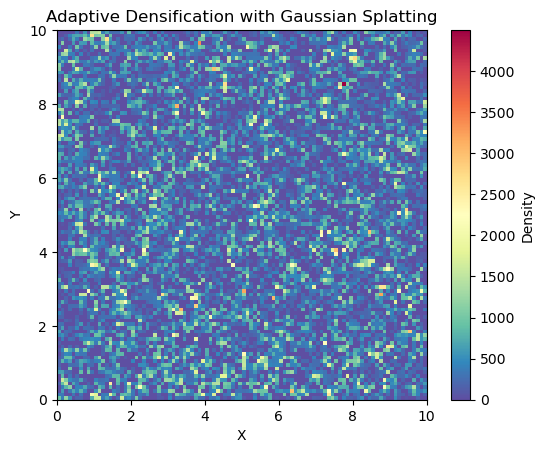

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def gaussian_splatting_adaptive_densification(points, values, grid_resolution):
    # Compute the bounding box of the point cloud
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    # Create a grid to perform splatting
    grid_dims = np.ceil((max_coords - min_coords) / grid_resolution).astype(int)
    grid = np.zeros(grid_dims)

    # Build a kd-tree for efficient nearest neighbor search
    tree = cKDTree(points)

    for idx, point in enumerate(points):
        # Query nearest neighbors
        neighbors_idx = tree.query_ball_point(point, 3 * grid_resolution)

        # Compute Gaussian weights based on distances
        distances = np.linalg.norm(points[neighbors_idx] - point, axis=1)
        weights = np.exp(-(distances ** 2) / (2 * (grid_resolution ** 2)))

        # Splat values onto the grid
        grid_indices = ((point - min_coords) / grid_resolution).astype(int)
        grid[grid_indices[0], grid_indices[1]] += np.sum(values[neighbors_idx] * weights)

    return grid

# Sample data generation (replace with your data)
np.random.seed(0)
num_points = 10000
points = np.random.rand(num_points, 2) * 10  # 2D points
values = np.random.rand(num_points) * 100  # Random values for each point

# Adaptive densification parameters
grid_resolution = 0.1  # Resolution of the grid

# Perform adaptive densification
grid = gaussian_splatting_adaptive_densification(points, values, grid_resolution)

# Plot the result
plt.imshow(grid, cmap='Spectral_r', extent=[0, 10, 0, 10], origin='lower')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Adaptive Densification with Gaussian Splatting')
plt.show()


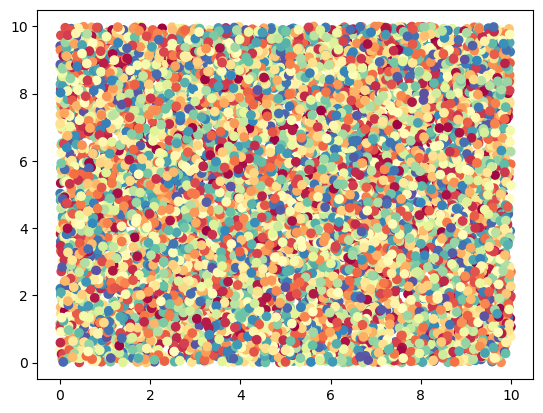

In [212]:
plt.scatter(points[:, 0], points[:, 1], c=values, cmap='Spectral_r')

In [218]:
import torch
import torch.nn.functional as F

# Define a quaternion normalization function
def normalize_quaternion(q):
    # Compute the magnitude of the quaternion
    magnitude = torch.sqrt(torch.sum(q ** 2, dim=-1, keepdim=True))
    # Divide each component of the quaternion by its magnitude
    normalized_q = q / magnitude
    return normalized_q

# Example usage:
# Create a quaternion tensor (batch_size x 4)
quaternion = torch.tensor([[0.5, 0.5, 0.5], [1.0, 2.0, 3.0]], dtype=torch.float32, requires_grad=True)

# Create a scaling matrix (3x3)
S = torch.tensor([[2.0, 0.0, 0.0],
                  [0.0, 3.0, 0.0],
                  [0.0, 0.0, 1.0]], dtype=torch.float32, requires_grad=True)

# Normalize the quaternion
normalized_quaternion = normalize_quaternion(quaternion)

# Transform the quaternion by the scaling matrix
transformed_quaternion = torch.matmul(S, normalized_quaternion.unsqueeze(-1)).squeeze(-1)

# Compute some loss or objective function
# For illustration, let's say we have some loss function
loss = torch.sum(transformed_quaternion ** 2)

# Backpropagation to compute gradients
loss.backward()

# Access gradients
print("Gradients of quaternion:", transformed_quaternion.grad)
print("Gradients of scaling matrix S:", S.grad)


Gradients of quaternion: None
Gradients of scaling matrix S: tensor([[1.6190, 1.9048, 2.1905],
        [2.8571, 3.7143, 4.5714],
        [1.0952, 1.5238, 1.9524]])


/tmp/ipykernel_12037/3603898137.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print("Gradients of quaternion:", transformed_quaternion.grad)


In [208]:
import torch
import torch.nn.functional as F

# Define a quaternion normalization function
def normalize_quaternion(q):
    # Compute the magnitude of the quaternion
    magnitude = torch.sqrt(torch.sum(q ** 2, dim=-1, keepdim=True))
    # Divide each component of the quaternion by its magnitude
    normalized_q = q / magnitude
    return normalized_q

# Define a function to convert quaternion to rotation matrix
def quaternion_to_rotation_matrix(q):
    # Normalize the quaternion
    q = normalize_quaternion(q)
    
    # Extract scalar (real) and vector (imaginary) parts
    w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

    # Compute elements of the rotation matrix
    xx = x * x
    xy = x * y
    xz = x * z
    xw = x * w
    yy = y * y
    yz = y * z
    yw = y * w
    zz = z * z
    zw = z * w

    # Construct the rotation matrix
    rotation_matrix = torch.stack([
        torch.stack([1 - 2 * (yy + zz), 2 * (xy - zw), 2 * (xz + yw)], dim=1),
        torch.stack([2 * (xy + zw), 1 - 2 * (xx + zz), 2 * (yz - xw)], dim=1),
        torch.stack([2 * (xz - yw), 2 * (yz + xw), 1 - 2 * (xx + yy)], dim=1)
    ], dim=1)

    return rotation_matrix

# Example usage:
# Create a quaternion tensor (batch_size x 4)
quaternion = torch.tensor([[0.5, 0.5, 0.5, 0.5], [1.0, 2.0, 3.0, 4.0]], dtype=torch.float32)

# Convert quaternion to rotation matrix
rotation_matrix = quaternion_to_rotation_matrix(quaternion)

print("Rotation matrices:")
print(rotation_matrix)


Rotation matrices:
tensor([[[ 0.0000,  0.0000,  1.0000],
         [ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000]],

        [[-0.6667,  0.1333,  0.7333],
         [ 0.6667, -0.3333,  0.6667],
         [ 0.3333,  0.9333,  0.1333]]])


In [209]:
rotation_matrix.shape

torch.Size([2, 3, 3])